In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pymatreader import read_mat
import scipy.signal as sig
from nilearn import plotting
import os
%matplotlib notebook

# Loads Data

In [3]:
# Loads structural connectivity matrix
mat = read_mat('../Simulation/Data/Connectivity/SC_90aal_32HCP.mat')
connect = mat['mat']
connect[connect < 10] = 0 # Discards connections with less than 10 detected fibers
np.fill_diagonal(connect, 0) # Fills diagonal with 0, so there are no self connections
connect /= np.max(connect) # Normalizes weights between 0 and 1

# loads tract length matrix
t_len = mat['mat_D']

# Loads ROI coordinates for brain plots
coords = read_mat('../Simulation/Data/Connectivity/roi_centers.mat')
coords = coords['roi_centers']

# To simulate only with cortical ROIs, set cortical to True
cortical = True
if cortical:
    # Picks only the cortical nodes
    mask = np.concatenate((np.arange(36),
                         np.array([38, 39]),
                         np.arange(42, 70),
                         np.arange(78, 90)))

    connect = connect[:, mask][mask]
    t_len = t_len[:, mask][mask]
    coords = coords[mask, :]
    
n_nodes = connect.shape[0]

# Connectivity plotting mask. This is to improve plots visually, it does not change results
plot_conn_mask = np.concatenate((np.arange(0, n_nodes, 2), np.arange(1, n_nodes, 2)[::-1]))

# Functional Connectivity

## BOLD

<IPython.core.display.Javascript object>


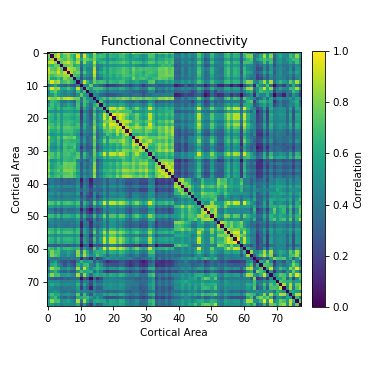

In [4]:
# Model parameters
K = 0.780
md = 3
rho = 0.22

# Loads timeseries
filename = f'../Simulation/Data/WC_results/BOLD/BOLD_K{K:.2f}_rho{np.around(rho, 2)}_md{int(md)}.npy'                                                                                                       
signal = np.load(filename)

# Bandpasses timeseries
fs = 1/0.72 # Hz. Sampling frequency
b, a = sig.butter(2, [0.008, 0.08], btype = 'band', output = 'ba', fs = fs)
signal = sig.filtfilt(b, a, signal, axis = 1)

# Computes functional connectivity
FC_matrix = np.corrcoef(signal)
np.fill_diagonal(FC_matrix, 0)

# Plots functional connectivity matrix
plt.figure(figsize = (5, 5))
plt.title('Functional Connectivity')
im = plt.imshow(FC_matrix[:, plot_conn_mask][plot_conn_mask], cmap = 'viridis')
c = plt.colorbar(im, fraction=0.046, pad=0.04)
plt.clim([0, 1])
c.set_label('Correlation')
plt.ylabel('Cortical Area')
plt.xlabel('Cortical Area')
plt.tight_layout()
plt.show()

## MEG

Here, we use theta-band signals as an example. The procedure is the same for the other frequency bands

<IPython.core.display.Javascript object>


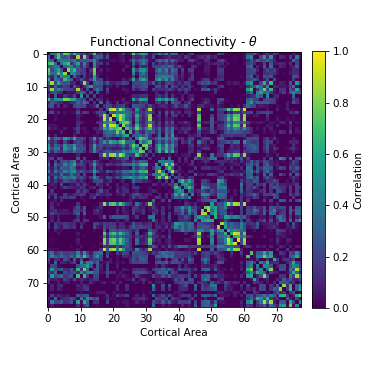

In [11]:
# Model parameters
K = 1.183
md = 3
rho = 0.22

# Loads timeseries
filename = f'../Simulation/Data/WC_results/MEG/MEG_K{K:.2f}_rho{np.around(rho, 2)}_md{int(md)}_theta_ds.npy'                                                                                                       
signal_theta = np.load(filename)

# Computes functional connectivity
FC_matrix_theta = np.corrcoef(signal_theta)
np.fill_diagonal(FC_matrix_theta, 0)

# Plots functional connectivity matrix
plt.figure(figsize = (5, 5))

plt.title(r'Functional Connectivity - $\theta$')
im = plt.imshow(FC_matrix_theta[:, plot_conn_mask][plot_conn_mask], cmap = 'viridis')
c = plt.colorbar(im, fraction=0.046, pad=0.04)
plt.clim([0, 1])
c.set_label('Correlation')
plt.ylabel('Cortical Area')
plt.xlabel('Cortical Area')

plt.tight_layout()
plt.show()

# Functional Connectivity Dynamics

## BOLD

<IPython.core.display.Javascript object>


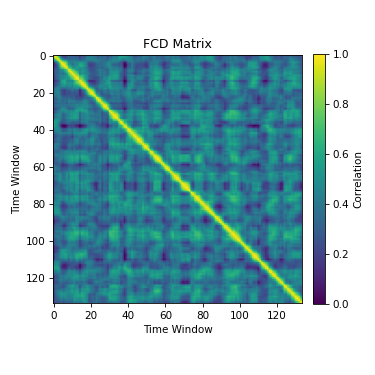

<IPython.core.display.Javascript object>


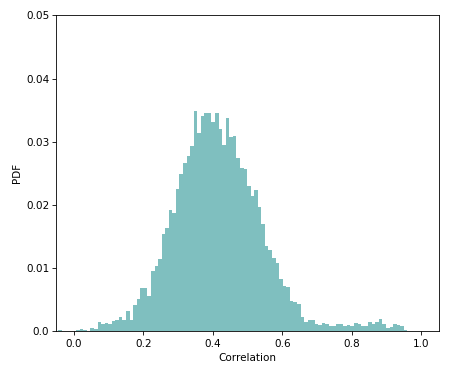

In [12]:
# Model parameters
K = 0.780
md = 3
rho = 0.22

# Loads timeseries
filename = f'../Simulation/Data/WC_results/BOLD/BOLD_K{K:.2f}_rho{np.around(rho, 2)}_md{int(md)}.npy'                                                                                                       
signal = np.load(filename)

# Bandpasses timeseries
fs = 1/0.72 # Hz. Sampling frequency
b, a = sig.butter(2, [0.008, 0.08], btype = 'band', output = 'ba', fs = fs)
signal = sig.filtfilt(b, a, signal, axis = 1)

# Computes functional connectivity dynamics
w_size = 80
w_step = 18
n_windows = int(np.floor((signal.shape[1] - w_size)/w_step))

FCD = np.zeros((n_windows, n_windows))
fc_vec = np.zeros((n_windows, n_nodes, n_nodes))        

for n in range(n_windows):
    sig_window = signal[:, n*w_step : n*w_step + w_size]
    fc_vec[n, ...] = np.corrcoef(sig_window)

for ii in range(n_windows):
    for jj in range(ii, n_windows):
        cc = np.corrcoef(fc_vec[ii, ...][np.triu_indices(n_nodes, k = 1)],
                         fc_vec[jj, ...][np.triu_indices(n_nodes, k = 1)])
        FCD[ii, jj] += cc[0, 1]

FCD += FCD.T
np.fill_diagonal(FCD, 1)
        
# Plots functional connectivity matrix
plt.figure(figsize = (5, 5))
plt.title('FCD Matrix')
im = plt.imshow(FCD, cmap = 'viridis')
c = plt.colorbar(im, fraction=0.046, pad=0.04)
plt.clim([0, 1])
c.set_label('Correlation')
plt.ylabel('Time Window')
plt.xlabel('Time Window')
plt.tight_layout()
plt.show()

# Plots FCD distribution
dist = FCD[np.triu_indices(FCD.shape[0], k = 1)]
plt.figure(figsize = (6, 5))
plt.hist(dist, bins = 100, color = 'teal', alpha = 0.5, density = True)
plt.yticks([0, 1, 2, 3, 4, 5], [0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.xlim([-0.05, 1.05])
plt.ylabel('PDF')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## MEG

Here, we use theta-band signals as an example. The procedure is the same for the other frequency bands

<IPython.core.display.Javascript object>


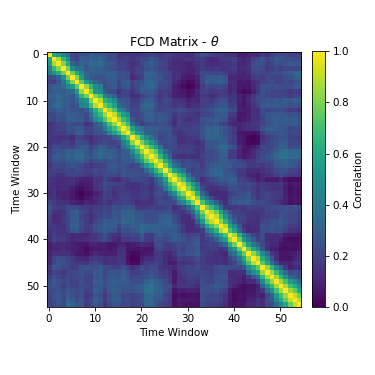

<IPython.core.display.Javascript object>


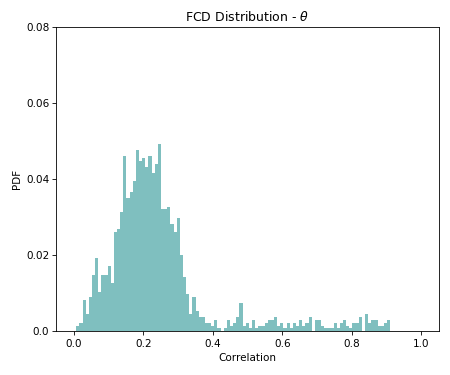

In [15]:
# Model parameters
K = 1.183
md = 3
rho = 0.22

# Loads timeseries
filename = f'../Simulation/Data/WC_results/MEG/MEG_K{K:.2f}_rho{np.around(rho, 2)}_md{int(md)}_theta_ds.npy'                                                                                                       
signal_theta = np.load(filename)

# FCD
fs = 5 #Hz. Sampling frequency of downsampled amplitude envelopes
w_size = int(30*fs)
w_step = int(6*fs)
n_windows = int(np.floor((signal_theta.shape[1] - w_size)/w_step))

FCD_theta = np.zeros((n_windows, n_windows))
fc_vec_theta = np.zeros((n_windows, n_nodes, n_nodes))

for n in range(n_windows):
    sig_window = signal_theta[:, n*w_step : n*w_step + w_size]
    fc_vec_theta[n, ...] = np.corrcoef(sig_window)

for ii in range(n_windows):
    for jj in range(ii, n_windows):
        cc = np.corrcoef(fc_vec_theta[ii, ...][np.triu_indices(n_nodes, k = 1)],
                         fc_vec_theta[jj, ...][np.triu_indices(n_nodes, k = 1)])
        FCD_theta[ii, jj] += cc[0, 1]

FCD_theta += FCD_theta.T
np.fill_diagonal(FCD_theta, 1)

# Plots functional connectivity matrices
plt.figure(figsize = (5, 5))

plt.title(r'FCD Matrix - $\theta$')
im = plt.imshow(FCD_theta, cmap = 'viridis')
c = plt.colorbar(im, fraction=0.046, pad=0.04)
plt.clim([0, 1])
c.set_label('Correlation')
plt.ylabel('Time Window')
plt.xlabel('Time Window')

plt.tight_layout()
plt.show()



# Plots FCD distribution
dist_theta = FCD_theta[np.triu_indices(FCD_theta.shape[0], k = 1)]


plt.figure(figsize = (6, 5))

plt.title(r'FCD Distribution - $\theta$')
plt.hist(dist_theta, bins = 100, color = 'teal', alpha = 0.5, density = True)
plt.yticks([0, 2, 4, 6, 8], [0.00, 0.02, 0.04, 0.06, 0.08])
plt.xlim([-0.05, 1.05])
plt.ylabel('PDF')
plt.xlabel('Correlation')

plt.tight_layout()
plt.show()

# Metastable Oscillatory Modes

In [17]:
def compute_moms(signal, fs = 250, th = 2):
    
    # Filters data in frequency band
    b_t, a_t = sig.butter(2, [4, 8], btype = 'band', output = 'ba', fs = fs)
    b_a, a_a = sig.butter(2, [8, 13], btype = 'band', output = 'ba', fs = fs)
    b_b, a_b = sig.butter(2, [13, 30], btype = 'band', output = 'ba', fs = fs)
    
    signal_theta = sig.filtfilt(b_t, a_t, signal, axis = 1)
    signal_alpha = sig.filtfilt(b_a, a_a, signal, axis = 1)
    signal_beta = sig.filtfilt(b_b, a_b, signal, axis = 1)
    
    # Removes first and last 2 seconds after band pass filtering
    signal_theta = signal_theta[:, 2*fs:-2*fs]
    signal_theta = (signal_theta - np.mean(signal_theta, axis = -1)[:, None]) / np.std(signal_theta, axis = -1)[:, None]
    
    signal_alpha = signal_alpha[:, 2*fs:-2*fs]
    signal_alpha = (signal_alpha - np.mean(signal_alpha, axis = -1)[:, None]) / np.std(signal_alpha, axis = -1)[:, None]
    
    signal_beta = signal_beta[:, 2*fs:-2*fs]
    signal_beta = (signal_beta - np.mean(signal_beta, axis = -1)[:, None]) / np.std(signal_beta, axis = -1)[:, None]
    
    # Calculates Hilbert amplitude envelopes
    signal_theta_ae = np.abs(sig.hilbert(signal_theta, axis=- 1))
    signal_alpha_ae = np.abs(sig.hilbert(signal_alpha, axis=- 1))
    signal_beta_ae = np.abs(sig.hilbert(signal_beta, axis=- 1))

    # Detects emergence of MOMs in each band.
    # Stores instances in time where amplitude envelopes in each frequency band are above the threshold  
    t_theta = np.zeros(signal_theta_ae.shape);
    t_alpha = np.zeros(signal_alpha_ae.shape);
    t_beta  = np.zeros(signal_beta_ae.shape);    
    for n in range(t_theta.shape[0]):
        t_theta[n, :] = signal_theta_ae[n, :] > th
        t_alpha[n, :] = signal_alpha_ae[n, :] > th
        t_beta[n, :] = signal_beta_ae[n, :] > th
        
    return t_theta, t_alpha, t_beta


def compute_moms_BOLD(signal, fs = 1/0.72, th = 2):
    
    ## Filters data in frequency band
    b, a = sig.butter(2, [0.008, 0.08], btype = 'band', output = 'ba', fs = fs)
    
    signal_BOLD = sig.filtfilt(b, a, signal, axis = 1)
    
    # Remove first and last 10 seconds after band pass filtering        
    signal_BOLD = signal_BOLD[:, int(10*fs):-int(10*fs)]
    signal_BOLD = (signal_BOLD - np.mean(signal_BOLD, axis = -1)[:, None]) / np.std(signal_BOLD, axis = -1)[:, None]
        
    # Calculate amplitude envelope
    signal_BOLD_ae = np.abs(sig.hilbert(signal_BOLD, axis=- 1))

    # Detects emergence of MOMs
    # Stores instances in time where amplitude envelopes in each frequency band are above the threshold  
    t_BOLD = np.zeros(signal_BOLD_ae.shape);
    for n in range(t_BOLD.shape[0]):
        t_BOLD[n, :] = signal_BOLD_ae[n, :] > th
        
    return t_BOLD

def MOM_features(MOM):
    
    # MOM duration
    n_nodes = MOM.shape[0]
    MOM_durations = []
    
    # Iterates across nodes
    for n in range(n_nodes):
        
        # Detect switches in and out of a MOM state
        a = np.argwhere(np.diff(MOM[n, :])==1) # Switches on
        b = np.argwhere(np.diff(MOM[n, :])==-1) # Switches off
        
        # If there are more switches off than on, removes the first switch off
        if len(b) > len(a):
            b = b[1:]
        
        # If there are more switches on than off, removes the last switch on
        elif len(a) > len(b):
            a = a[:-1]
        
        # If there are the same number of switches on and off, but the first switch on occurs after
        # The first switch off, removes the first switch off and the last switch on
        elif len(a) > 0 and len(b) > 0 and a[0] > b[0]:
            b = b[1:]
            a = a[:-1]
        
        # Adds durations to list
        MOM_durations += list(b-a)
            
    # MOM sizes are calculated as the number of regions enganged in a MOM at each point in time
    MOM_size = np.sum(MOM, axis = 0)
    MOM_size = MOM_size[MOM_size > 0]
    
    # MOM Occupancy
    MOM_occupancy = np.sum(MOM) / MOM.size
    
    return np.array(MOM_durations), MOM_size, MOM_occupancy 

## BOLD

In [44]:
# Model parameters
K = 0.780
md = 3
rho = 0.22

# Loads timeseries
filename = f'../Simulation/Data/WC_results/BOLD/BOLD_K{K:.2f}_rho{np.around(rho, 2)}_md{int(md)}.npy'                                                                                                       
signal = np.load(filename)

# Detects MOMs
MOM_BOLD = compute_moms_BOLD(signal, fs = 1/0.72, th = 2)

# Computes MOM features
BOLD_dur, BOLD_size, BOLD_occupancy = MOM_features(MOM_BOLD)

### Plots signal with detected MOMs

<IPython.core.display.Javascript object>


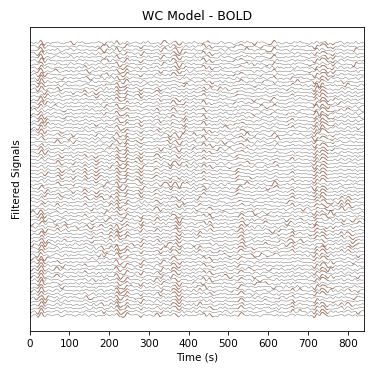

In [45]:
# Filters data in respective frequency band
fs = 1/(0.72)
b, a = sig.butter(2, [0.008, 0.08], btype = 'band', output = 'ba', fs = fs)

signal_BOLD = sig.filtfilt(b, a, signal, axis = 1)

# Remove first and last 10 seconds after band pass filtering        
signal_BOLD = signal_BOLD[:, int(10*fs):-int(10*fs)]
signal_BOLD = (signal_BOLD - np.mean(signal_BOLD, axis = -1)[:, None]) / np.std(signal_BOLD, axis = -1)[:, None]

plt.figure(figsize = (5, 5))
plt.title(r'WC Model - BOLD')
plt.plot(np.arange(signal_BOLD.shape[-1])/(fs), signal_BOLD.T + 4 * np.r_[:78], 
         color = 'k', alpha = 0.5, linewidth = 0.5)

MOM_BOLD_aux = MOM_BOLD.copy()
MOM_BOLD_aux[MOM_BOLD_aux == 0] = np.nan

plt.plot(np.arange(signal_BOLD.shape[-1])/(fs), 
         (signal_BOLD * MOM_BOLD_aux).T + 4 * np.r_[:78], color = 'sienna', alpha = 0.5, linewidth = 1)

plt.xlabel('Time (s)')
plt.xlim([0, 840])
plt.yticks([])
plt.ylabel('Filtered Signals')
plt.tight_layout()
plt.show()

### Plots the distributions of MOM sizes and durations

<IPython.core.display.Javascript object>


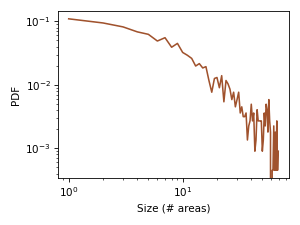

In [46]:
# Creates array containing all the possible values of MOM sizes, from 1 to the maximum size
sizes_BOLD = np.arange(1,  np.max(BOLD_size)+1)

# Counts number of MOms with each size
size_dist_BOLD = np.zeros(len(sizes_BOLD))
for i in range(len(sizes_BOLD)):
    size_dist_BOLD[i] = np.sum(BOLD_size == (i+1))

# Divides by the total number of detected MOMs to get a probability distribution
size_dist_BOLD /= len(BOLD_size)


# Plots distribution of sizes
plt.figure(figsize = (4, 3))
plt.plot(sizes_BOLD, size_dist_BOLD, color = 'sienna')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('Size (# areas)')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


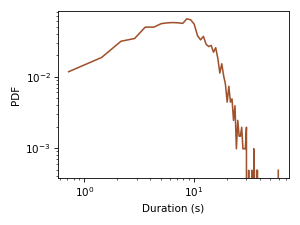

In [47]:
# Creates array containing all the possible values of MOM durations, from 1 to the maximum duration
durs_BOLD = np.arange(1,  np.max(BOLD_dur)+1)

# Counts number of MOms with each duration (in number of samples)
dur_dist_BOLD = np.zeros(len(durs_BOLD))
for i in range(len(durs_BOLD)):
    dur_dist_BOLD[i] = np.sum(BOLD_dur == (i+1))

dur_dist_BOLD /= len(BOLD_dur)

# Divides durations by the sampling frequency to obtain durations in seconds
durs_BOLD = durs_BOLD/(1/0.72)

# Plots distribution of durations
plt.figure(figsize = (4, 3))
plt.plot(durs_BOLD, dur_dist_BOLD, color = 'sienna')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('Duration (s)')
plt.tight_layout()
plt.show()

## MEG

Here, we use theta-band signals as an example. The procedure is the same for the other frequency bands

In [48]:
# Model parameters
K = 1.183
md = 3
rho = 0.22

filename = '../Simulation/Data/WC_results/MEG/MEG_K{}_rho{}_md{}.npy'.format(np.around(K, 2), 
                                                                             np.around(rho, 2),
                                                                             int(md))  

signal = np.load(filename)

# Detects MOMs
MOM_theta, MOM_alpha, MOM_beta = compute_moms(signal, fs = 250, th = 2)

# Computes MOM features
theta_dur, theta_size, theta_occupancy = MOM_features(MOM_theta)

### Plots signal with detected MOMs

<IPython.core.display.Javascript object>


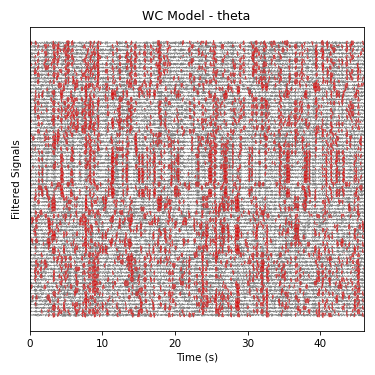

In [55]:
# Filters data in respective frequency band
fs = 250
b, a = sig.butter(2, [4, 8], btype = 'band', output = 'ba', fs = fs)

signal_theta = sig.filtfilt(b, a, signal, axis = 1)

# Remove first and last 2 seconds after band pass filtering        
signal_theta = signal_theta[:, int(2*fs):-int(2*fs)]
signal_theta = (signal_theta - np.mean(signal_theta, axis = -1)[:, None]) / np.std(signal_theta, axis = -1)[:, None]

plt.figure(figsize = (5, 5))
plt.title(r'WC Model - theta')
plt.plot(np.arange(signal_theta.shape[-1])/(fs), signal_theta.T + 4 * np.r_[:78], 
         color = 'k', alpha = 0.5, linewidth = 0.5)

MOM_theta_aux = MOM_theta.copy()
MOM_theta_aux[MOM_theta_aux == 0] = np.nan

plt.plot(np.arange(signal_theta.shape[-1])/(fs), 
         (signal_theta * MOM_theta_aux).T + 4 * np.r_[:78], color = 'r', alpha = 0.5, linewidth = 1)

plt.xlabel('Time (s)')
plt.xlim([0, 46])
plt.yticks([])
plt.ylabel('Filtered Signals')
plt.tight_layout()
plt.show()

### Plots the distributions of MOM sizes and durations

<IPython.core.display.Javascript object>


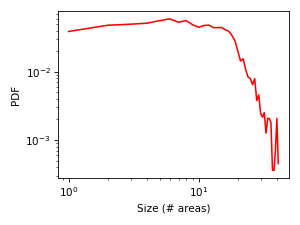

In [56]:
# Creates array containing all the possible values of MOM sizes, from 1 to the maximum size
sizes_theta = np.arange(1,  np.max(theta_size)+1)

# Counts number of MOms with each size
size_dist_theta = np.zeros(len(sizes_theta))
for i in range(len(sizes_theta)):
    size_dist_theta[i] = np.sum(theta_size == (i+1))

# Divides by the total number of detected MOMs to get a probability distribution
size_dist_theta /= len(theta_size)


# Plots distribution of sizes
plt.figure(figsize = (4, 3))
plt.plot(sizes_theta, size_dist_theta, color = 'r')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('Size (# areas)')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


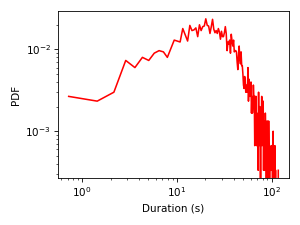

In [57]:
# Creates array containing all the possible values of MOM durations, from 1 to the maximum duration
durs_theta = np.arange(1,  np.max(theta_dur)+1)

# Counts number of MOms with each duration (in number of samples)
dur_dist_theta = np.zeros(len(durs_theta))
for i in range(len(durs_theta)):
    dur_dist_theta[i] = np.sum(theta_dur == (i+1))

dur_dist_theta /= len(theta_dur)

# Divides durations by the sampling frequency to obtain durations in seconds
durs_theta = durs_theta/(250)

# Plots distribution of durations
plt.figure(figsize = (4, 3))
plt.plot(durs_theta, dur_dist_theta, color = 'r')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('Duration (s)')
plt.tight_layout()
plt.show()

# Correlation between SC and Simulated FC

## BOLD

<IPython.core.display.Javascript object>


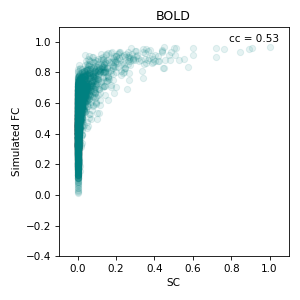

<IPython.core.display.Javascript object>


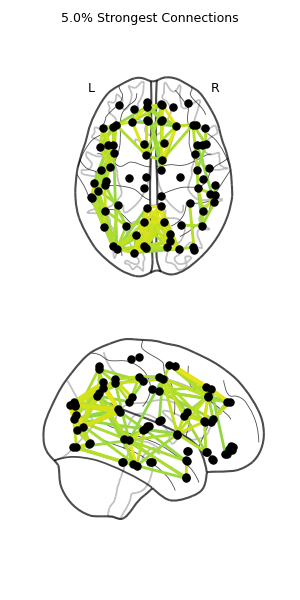

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4756\1522422820.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [63]:
# Model parameters
K = 0.780
md = 3
rho = 0.22

filename = '../Simulation/Data/WC_results/BOLD/BOLD_K{}_rho{}_md{}.npy'.format(np.around(K, 2), 
                                                                                np.around(rho, 2),
                                                                                int(md))  

signal = np.load(filename)

# Bandpasses the signal
fs = 1/(0.72)
b, a = sig.butter(2, [0.008, 0.08], btype = 'band', output = 'ba', fs = fs)
signal = sig.filtfilt(b, a, signal, axis = 1)

# Computes functional connectivity
model_FC = np.corrcoef(signal)

plt.figure(figsize = (4, 4))
plt.title('BOLD')
plt.scatter(connect[np.triu_indices(n_nodes, k=1)], 
            model_FC[np.triu_indices(n_nodes, k=1)],
            alpha  = 0.1, color = 'teal')
plt.xlabel('SC')
plt.ylabel('Simulated FC')
# Computes the correlation between structural and functional connectivity
cc = np.corrcoef(connect[np.triu_indices(n_nodes, k=1)], 
                 model_FC[np.triu_indices(n_nodes, k=1)])[0, 1]
plt.text(1.05, 1.05, f'cc = {cc:.2f}', ha = 'right', va = 'top')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.4, 1.1])
plt.tight_layout()
plt.show()


# Plots 5% strongest functional connections
th_density = 0.05
aux_FC = model_FC.copy()
th = np.sort(aux_FC[np.triu_indices(n_nodes, k = 1)])[int((1-th_density) * len(aux_FC[np.triu_indices(n_nodes, k = 1)]))]
aux_FC[aux_FC < th] = 0

plt.figure(figsize = (4, 8))
plt.suptitle(f'{(100*th_density):.1f}% Strongest Connections')
ax = plt.subplot(2, 1, 1)
plotting.plot_connectome(aux_FC, coords, 
                         node_color = 'k', display_mode = 'z', axes = ax, 
                         edge_vmin = 0, edge_vmax = 1, edge_cmap = 'viridis')

ax = plt.subplot(2, 1, 2)
plotting.plot_connectome(aux_FC, coords, 
                         node_color = 'k', display_mode = 'x', axes = ax,
                         edge_vmin = 0, edge_vmax = 1, edge_cmap = 'viridis')

plt.tight_layout()
plt.show()